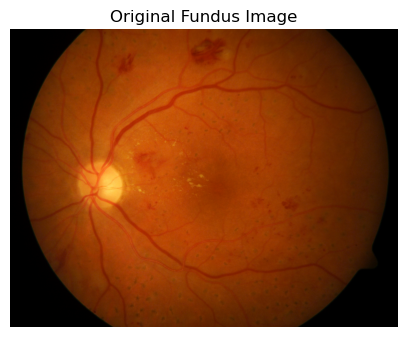

In [226]:
# RETINAL BLOOD VESSEL SEGMENTATION PIPELINE 
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import img_as_bool, img_as_ubyte
from PIL import Image

# Set up folders 
INPUT_FOLDER = 'images/'
PREPROC_FOLDER = 'preprocessed/'
RESULT_FOLDER = 'results/segmented_enhanced/'

# Create folders
os.makedirs(PREPROC_FOLDER + 'gray', exist_ok=True)
os.makedirs(PREPROC_FOLDER + 'clahe', exist_ok=True)
os.makedirs(PREPROC_FOLDER + 'od_removed', exist_ok=True)
os.makedirs(PREPROC_FOLDER + 'blurred', exist_ok=True)
os.makedirs(RESULT_FOLDER, exist_ok=True)

# Select a sample image for visualization 
sample_image = 'diaretdb1_image008.png'
sample_base = os.path.splitext(sample_image)[0]

# Load and visualize original 
original_img = Image.open(os.path.join(INPUT_FOLDER, sample_image))
plt.figure(figsize=(5, 5))
plt.imshow(original_img)
plt.axis('off')
plt.title("Original Fundus Image")
plt.show()


In [227]:
# PREPROCESSING PIPELINE (AIM 1: Develop a preprocessing pipeline for retinal fundus images + OD removal)
for filename in os.listdir(INPUT_FOLDER):
    if filename.endswith(('.png', '.jpg')):
        img_path = os.path.join(INPUT_FOLDER, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue

        name, _ = os.path.splitext(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(f'{PREPROC_FOLDER}gray/{name}_gray.png', gray)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(gray)
        cv2.imwrite(f'{PREPROC_FOLDER}clahe/{name}_clahe.png', clahe_img)

        _, thresh = cv2.threshold(clahe_img, 220, 255, cv2.THRESH_BINARY)
        kernel = np.ones((15, 15), np.uint8)
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
        contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros_like(clahe_img)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            cv2.drawContours(mask, [largest], -1, 255, -1)
        od_removed = clahe_img.copy()
        od_removed[mask == 255] = 0
        cv2.imwrite(f'{PREPROC_FOLDER}od_removed/{name}_od_removed.png', od_removed)

        blurred = cv2.GaussianBlur(od_removed, (5, 5), 0)
        cv2.imwrite(f'{PREPROC_FOLDER}blurred/{name}_blurred.png', blurred)
        print(f"Preprocessed: {filename}")


Preprocessed: diaretdb1_image074.png
Preprocessed: diaretdb1_image060.png
Preprocessed: diaretdb1_image048.png
Preprocessed: diaretdb1_image049.png
Preprocessed: diaretdb1_image061.png
Preprocessed: diaretdb1_image075.png
Preprocessed: diaretdb1_image088.png
Preprocessed: diaretdb1_image063.png
Preprocessed: diaretdb1_image077.png
Preprocessed: diaretdb1_image076.png
Preprocessed: diaretdb1_image062.png
Preprocessed: diaretdb1_image089.png
Preprocessed: diaretdb1_image066.png
Preprocessed: diaretdb1_image072.png
Preprocessed: diaretdb1_image073.png
Preprocessed: diaretdb1_image067.png
Preprocessed: diaretdb1_image059.png
Preprocessed: diaretdb1_image071.png
Preprocessed: diaretdb1_image065.png
Preprocessed: diaretdb1_image064.png
Preprocessed: diaretdb1_image070.png
Preprocessed: diaretdb1_image058.png
Preprocessed: diaretdb1_image017.png
Preprocessed: diaretdb1_image003.png
Preprocessed: diaretdb1_image002.png
Preprocessed: diaretdb1_image016.png
Preprocessed: diaretdb1_image014.png
P

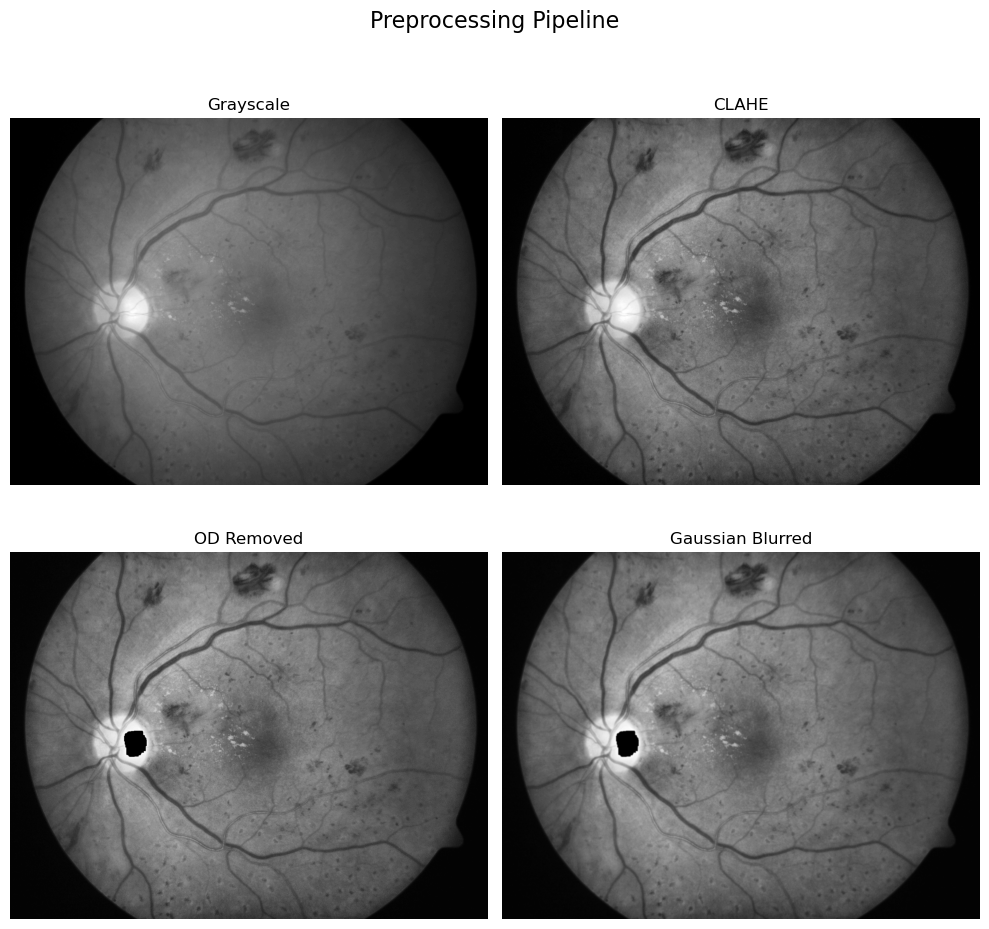

In [228]:
# DISPLAY PREPROCESSING STEPS FOR SAMPLE IMAGE 
if os.path.exists(f'{PREPROC_FOLDER}gray/{sample_base}_gray.png'):
    gray = cv2.imread(f'{PREPROC_FOLDER}gray/{sample_base}_gray.png', cv2.IMREAD_GRAYSCALE)
    clahe_img = cv2.imread(f'{PREPROC_FOLDER}clahe/{sample_base}_clahe.png', cv2.IMREAD_GRAYSCALE)
    od_removed = cv2.imread(f'{PREPROC_FOLDER}od_removed/{sample_base}_od_removed.png', cv2.IMREAD_GRAYSCALE)
    blurred = cv2.imread(f'{PREPROC_FOLDER}blurred/{sample_base}_blurred.png', cv2.IMREAD_GRAYSCALE)

    steps = [gray, clahe_img, od_removed, blurred]
    titles = ['Grayscale', 'CLAHE', 'OD Removed', 'Gaussian Blurred']
    plt.figure(figsize=(10, 10))  # Width x Height
    
    for i, (img_step, title) in enumerate(zip(steps, titles)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(img_step, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.suptitle("Preprocessing Pipeline", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for title
    plt.show()

In [229]:
# SEGMENTATION PIPELINE (AIM 2: Implement and refine blood vessel segmentation techniques)
for filename in os.listdir(PREPROC_FOLDER + 'blurred'):
    if filename.endswith('.png'):
        path = os.path.join(PREPROC_FOLDER, 'blurred', filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                         cv2.THRESH_BINARY_INV, 15, 10)
        edges = cv2.Canny(img, 30, 90)
        combined = cv2.bitwise_or(adaptive, edges)
        kernel = np.ones((3, 3), np.uint8)
        morph = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
        morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)
        skeleton = skeletonize(img_as_bool(morph))
        final = img_as_ubyte(skeleton)

        name, _ = os.path.splitext(filename)
        cv2.imwrite(os.path.join(RESULT_FOLDER, f'{name}_segmented.png'), final)
        print(f"Segmented: {filename}")

Segmented: diaretdb1_image063_blurred.png
Segmented: diaretdb1_image013_blurred.png
Segmented: diaretdb1_image021_blurred.png
Segmented: diaretdb1_image051_blurred.png
Segmented: diaretdb1_image082_blurred.png
Segmented: diaretdb1_image034_blurred.png
Segmented: diaretdb1_image044_blurred.png
Segmented: diaretdb1_image058_blurred.png
Segmented: diaretdb1_image028_blurred.png
Segmented: diaretdb1_image076_blurred.png
Segmented: diaretdb1_image006_blurred.png
Segmented: diaretdb1_image041_blurred.png
Segmented: diaretdb1_image031_blurred.png
Segmented: diaretdb1_image003_blurred.png
Segmented: diaretdb1_image073_blurred.png
Segmented: diaretdb1_image038_blurred.png
Segmented: diaretdb1_image048_blurred.png
Segmented: diaretdb1_image016_blurred.png
Segmented: diaretdb1_image066_blurred.png
Segmented: diaretdb1_image087_blurred.png
Segmented: diaretdb1_image054_blurred.png
Segmented: diaretdb1_image024_blurred.png
Segmented: diaretdb1_image057_blurred.png
Segmented: diaretdb1_image027_blur

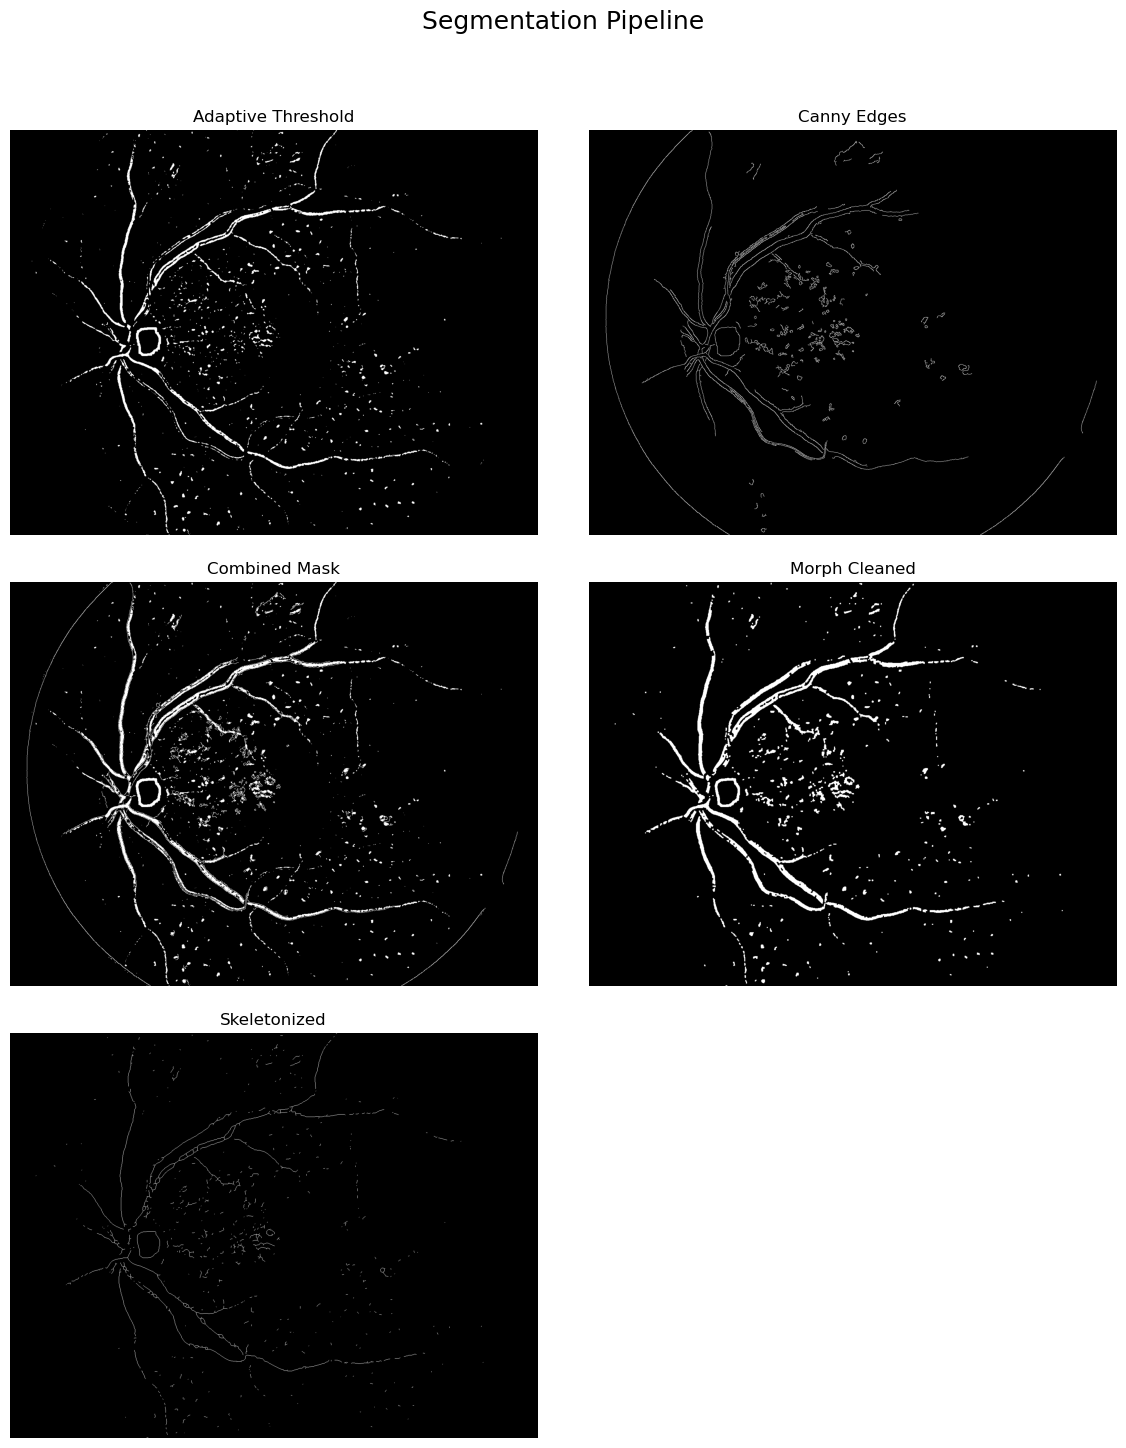

In [230]:
# DISPLAY SEGMENTATION STEPS FOR SAMPLE IMAGE 
sample_blur_path = f'{PREPROC_FOLDER}blurred/{sample_base}_blurred.png'
if os.path.exists(sample_blur_path):
    img = cv2.imread(sample_blur_path, cv2.IMREAD_GRAYSCALE)
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV, 15, 10)
    edges = cv2.Canny(img, 30, 90)
    combined = cv2.bitwise_or(adaptive, edges)
    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)
    skeleton = skeletonize(img_as_bool(morph))
    final = img_as_ubyte(skeleton)

    steps = [adaptive, edges, combined, morph, final]
    titles = ['Adaptive Threshold', 'Canny Edges', 'Combined Mask', 'Morph Cleaned', 'Skeletonized']
    plt.figure(figsize=(12, 15))  # Adjust size as needed
    for i, (img_step, title) in enumerate(zip(steps, titles)):
        plt.subplot(3, 2, i + 1)  # 3 rows, 2 columns
        plt.imshow(img_step, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.suptitle("Segmentation Pipeline", fontsize=18)
    plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.98])  # pad increases spacing between plots
    plt.show()